# Homework Program HMM Timur Khuzin

### Function that read parameters.

All lines started with `#` are ignored

First line of file: M,K,L tab separated<br>
Than M lines of M numbers (MxM transition matrix)<br>
Row index is old state, column index is next state<br>
Than M lines of K numbers (MxK emisstion matrix)<br>
Each row of emission matrix is probabilities of K emissions.<br>
Than M numbers in line (Vector of M — initial distribution)<br>

In [284]:
import numpy as np

class HMM_Params:
    def __init__(self, state_num, emission_num, to_observe):
        self.state_num = state_num
        self.emission_num = emission_num
        self.observation_length = to_observe
        self.transition_matrix = np.zeros((state_num, state_num), dtype='float64')
        self.emission_matrix = np.zeros((state_num, emission_num), dtype='float64')
        self.beginning_distribution = np.zeros((state_num), dtype='float64')

def read_params(filename):
    def read_non_comment(f):
        s = f.readline()
        while(s[0]=='#'):
            s = f.readline()
        return s
    with open(filename, 'r') as f:
        M, K, L = map(int, read_non_comment(f).strip().split())
        params = HMM_Params(M, K, L)
        
        for i in range(M):
            params.transition_matrix[i,:] =  [float(x) for x in read_non_comment(f).strip().split()]
            params.transition_matrix[i,:] /= np.sum(params.transition_matrix[i,:])
            
        for i in range(M):
            params.emission_matrix[i,:] = [float(x) for x in read_non_comment(f).strip().split()]
            params.emission_matrix[i,:]/= np.sum(params.emission_matrix[i,:])
        
        params.beginning_distribution[:] = np.array([float(x) for x in read_non_comment(f).strip().split()])
        params.beginning_distribution[:] /= np.sum(params.beginning_distribution[:])
        
        return params

### HMM generator

In [285]:
from numpy.random import choice as npchoice

# params is HMM_Params
# returns sequence of tuples: (pi, x)
def generate_random_HMM(params):
    current_pos = npchoice(params.state_num,1, p=params.beginning_distribution)[0]
    current_emission = npchoice(params.emission_num, 1, p=params.emission_matrix[current_pos,:])[0]
    result = []
    while len(result)<params.observation_length:
        result.append((current_pos, current_emission))
        current_pos = npchoice(params.state_num, 1, p=params.transition_matrix[current_pos,:])[0]
        current_emission = npchoice(params.emission_num, 1, p=params.emission_matrix[current_pos,:])[0]
    return result

def beautify_HMM_sequence(hmm_seq):
    def beautify_pair(p):
        return 'p%d'%p[0], 'e%d'%p[1]
    return [beautify_pair(x) for x in hmm_seq]

def print_HMM_to_file(hmm, filename):
    hmm = beautify_HMM_sequence(hmm)
    with open(filename, 'w') as f:
        f.write('\n'.join(map(lambda p:'%s\t%s'%p, hmm)))

In [286]:
params = read_params('test.txt')
hmm = generate_random_HMM(params)
print_HMM_to_file(hmm, 'generated_path.txt')
#beautify_HMM_sequence(hmm)

In [287]:
# input is HMM_Params and observation list (with ints inside)
# output is hidden states in integer list
def viterbi_solver(params, observations):
    # matrix LxM where stored previous states for each state in row
    parents = np.zeros((params.observation_length, params.state_num), dtype='float64')
    # current probabilities
    current_iter = np.log(params.beginning_distribution) + np.log(params.emission_matrix[:,observations[0]])
    # probabilities of next step
    next_generation = np.zeros(params.state_num,dtype='float64')
    for i in range(1, params.observation_length):
        for state in range(params.state_num):
            probs = current_iter + np.log(params.transition_matrix[:,state])
            prev = probs.argmax()
            next_generation[state] = probs[prev] + np.log(params.emission_matrix[state, observations[i]])
            parents[i,state] = prev
        # avoid garbage collection
        current_iter, next_generation = next_generation, current_iter
    
    path = np.ones(params.observation_length, dtype='int64')
    path[-1] = current_iter.argmax()
    for i in range(params.observation_length - 2, -1, -1):
        p = parents[i+1, path[i+1]]
        path[i] = p
    return path

In [288]:
# checking viterbi
params = read_params('test.txt')
data = [x.strip() for x in open('generated_path.txt', 'r')]
observations = [int(x.split()[1][1:]) for x in data]
actual_states = [int(x.split()[0][1:]) for x in data]
most_probable = viterbi_solver(params, observations)
with open('viterbi.txt', 'w') as f:
    f.write("RPath\tObserv\tViterbi\n")
    p = map(lambda x: '%s\tp%d'%x, zip(data, most_probable))
    p = list(p)
    f.write('\n'.join(p))
same_indices = [i for i in range(len(data)) if actual_states[i]==most_probable[i]]
print("Accuracy: %f"%(len(same_indices)/len(data)))

Accuracy: 0.690000


In [289]:
from scipy.special import logsumexp

# returns 3 elems: 
#  terminating probability, 
#  list of logs of probability of subsequence from start to index
#  and the matrix for posterior
def forward_algorithm(params, observations):
    observe_len = len(observations)
    prob_matrix = np.zeros((observe_len+1, params.state_num), dtype='float64')
    prob_matrix[-1,:] = np.log(1/params.state_num) # initial state
    for i in range(observe_len):
        for nxt in range(params.state_num):
            probs = np.log(params.transition_matrix[:,nxt]) + prob_matrix[i-1,:]
            prob_matrix[i, nxt] = np.log(params.emission_matrix[nxt, observations[i]]) + logsumexp(probs)
    res = logsumexp(prob_matrix[:observe_len,:], axis=1)
    return np.exp(res[-1]), res, prob_matrix

In [290]:
prob, _, matr = forward_algorithm(params, observations)
prob

1.7488011397641267e-60

In [291]:
# returns 3 elems: 
#  terminating probability, 
#  log of terminating probability
#  and the matrix for posterior
def backward_algorithm(params, observations):
    observe_len = len(observations)
    matrix = np.zeros((observe_len, params.state_num), dtype='float64')
    matrix[-1,:] = 1
    for i in range(observe_len-2, -1, -1):
        for prev in range(params.state_num):
            probs = np.log(params.transition_matrix[prev,:])+\
                    np.log(params.emission_matrix[:,observations[i+1]])+\
                    matrix[i+1,:]
            matrix[i, prev] = logsumexp(probs)
    probs = np.log(params.transition_matrix[0,:])+\
                    np.log(params.emission_matrix[:,observations[0]])+\
                    matrix[0,:]
    res = logsumexp(probs)
    return np.exp(res), res, matrix

In [292]:
backward_algorithm(params, observations)[0]

6.032879424268106e-60

In [293]:
# returns probabilities for each state in each iteration
# iteration is row, state is column
def posterior_decoding(params, observations):
    probability, prob_log, forward_matr = forward_algorithm(params, observations)
    backward_prob, back_log, backward_matr = backward_algorithm(params, observations)
    out_probs = np.zeros((len(observations), params.state_num), dtype='float64')
    for i in range(len(observations)):
        out_probs[i, :] = forward_matr[i, :] + backward_matr[i,:] - prob_log[i]
    out_probs = np.exp(out_probs)
    # even if it not described in lecture, I suppose that probabilities need to be normalized for use
    for i in range(len(observations)):
        out_probs[i,:] /= np.sum(out_probs[i,:])
    return out_probs

In [294]:
posterior_decoding(params, np.array(observations))[:10]

array([[0.83635269, 0.16364731],
       [0.81246237, 0.18753763],
       [0.48910874, 0.51089126],
       [0.6943359 , 0.3056641 ],
       [0.42714803, 0.57285197],
       [0.62542565, 0.37457435],
       [0.25039512, 0.74960488],
       [0.16078353, 0.83921647],
       [0.16159229, 0.83840771],
       [0.25458132, 0.74541868]])

# Unfair casino

In [300]:
from matplotlib import pyplot as plt

casino_params = read_params('casino_in.txt')
casino_hmm = generate_random_HMM(casino_params)
print_HMM_to_file(casino_hmm, 'generated_casino_path.txt')
hidden_states = np.array([x[0] for x in casino_hmm], dtype=int)
casino_observes = np.array([x[1] for x in casino_hmm], dtype=int)

### viterbi

Accuracy: 0.845000


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


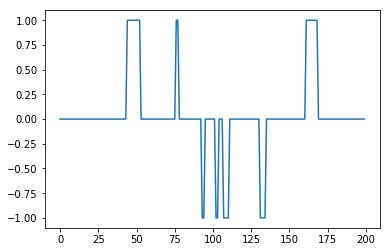

In [301]:

most_probable = viterbi_solver(casino_params, casino_observes)
with open('casino_viterbi.txt', 'w') as f:
    f.write("Hidden\tObserved\tViterbi\n")
    p = map(lambda x: 'p%d\te%d\tp%d'%x, map(lambda x:(x[0][0], x[0][1], x[1]),zip(casino_hmm, most_probable)))
    p = list(p)
    f.write('\n'.join(p))
same_indices = [i for i in range(len(casino_hmm)) if hidden_states[i]==most_probable[i]]
print("Accuracy: %f"%(len(same_indices)/len(casino_hmm)))
# plot difference between actual and estimate
# if upper zero, real is loaded dice, estimate is fair
# if lower zero, real is fair, estimate is loaded
# if same, there is correct estimate
plt.plot(np.arange(len(casino_hmm)), hidden_states-most_probable)

### posterior

Plot of hidden values is reflected on Ox to better visualization.<br>

Accuracy: 0.830000


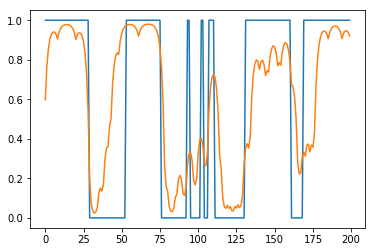

In [302]:
probabilities = posterior_decoding(casino_params, np.array(casino_observes))
# calculation of accuracy
estimate = [probabilities[i].argmax() for i in range(len(casino_observes))]
same_indices = [i for i in range(len(casino_hmm)) if hidden_states[i]==estimate[i]]
print("Accuracy: %f"%(len(same_indices)/len(casino_hmm)))

# calculation of plot
plt.plot(np.arange(len(casino_hmm)), -hidden_states+1)
plt.plot(np.arange(len(casino_hmm)), probabilities[:,0])